# 🧪 Lab: Modelling & Model Lifecycle — Predicting Plant Production (GIST Steel Dataset)

---

## 🎯 Learning Outcomes

By completing this lab, you will be able to:

- Prepare and analyse a dataset for modelling.  
- Train and evaluate regression models.  
- Apply cross-validation and hyperparameter tuning using scikit-learn.  
- Track experiments and store models using MLflow and/or Optuna.  
- Reflect on the practical aspects of managing the ML lifecycle.

---



## 🧩 1. Data Setup and Exploration
⏱ *Estimated time: 30–40 min*

### 🧭 Objective  
Understand the dataset structure and the target variable (“plant-level production”).

---

### **Task 1.1 – Load and Inspect Data**
- Load the GIST Steel dataset. 
- Display basic info (shape, column names, missing values, and data types).  
- Identify the target variable (production) and key features (capacity, ...).


#### Imports

In [1]:
# !uv add pandas numpy matplotlib seaborn scikit-learn mlflow optuna joblib

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

# Experiment tracking
import mlflow
import mlflow.sklearn
import optuna
import joblib

#### Hyperparameters

In [3]:
XLSX_DATA_PATH = Path("../lab1/data/dataSept2025.xlsx")
ON_COLAB = False # Put false if executed in another environement than Google Colab

#### Functions

In [4]:
def get_dataframe(file_path, sheet_names, key_col):
    """Load and merge multiple Excel sheets"""
    read_df = lambda s: pd.read_excel(file_path, sheet_name=s)
    dfs = [read_df(s) for s in sheet_names]
    
    for df in dfs:
        df.set_index(key_col, inplace=True)
    
    return pd.merge(dfs[0], dfs[1], on=key_col).merge(dfs[2], on=key_col)


#### Run

In [5]:

# Task 1.1 - Load and Inspect Data
# Load the data
merged_df = get_dataframe(XLSX_DATA_PATH, ["Plant data", "Plant capacities and status", "Plant production"], "Plant ID")

# Convert all column names to strings
merged_df.columns = merged_df.columns.map(str)

print("Dataset shape:", merged_df.shape)
print("\nColumn names:")
print(merged_df.columns.tolist())
print("\nData types:")
print(merged_df.dtypes.value_counts())
print("\nMissing values per column:")
print(merged_df.isnull().sum().sort_values(ascending=False).head(10))


Dataset shape: (3243, 65)

Column names:
['Plant name (English)_x', 'Plant name (other language)_x', 'Other plant names (English)', 'Other plant names (other language)', 'Owner', 'Owner (other language)', 'Owner GEM ID', 'Owner PermID', 'SOE Status', 'Parent', 'Parent GEM ID', 'Parent PermID', 'Location address', 'Municipality', 'Subnational unit (province/state)', 'Country/Area_x', 'Region', 'Other language location address', 'Coordinates', 'Coordinate accuracy', 'GEM wiki page', 'Plant age (years)', 'Announced date', 'Construction date', 'Start date_x', 'Pre-retirement announcement date', 'Idled date', 'Retired date', 'Ferronickel capacity (ttpa)', 'Sinter plant capacity (ttpa)', 'Coking plant capacity (ttpa)', 'Pelletizing plant capacity (ttpa)', 'Category steel product', 'Steel products', 'Steel sector end users', 'Workforce size', 'ISO 14001', 'ISO 50001', 'ResponsibleSteel Certification', 'Main production equipment', 'Power source', 'Iron ore source', 'Met coal source', 'Plant na


> 📝 *Markdown prompt:*  
Describe any patterns or potential data quality issues you notice. Which variables might strongly influence production?

---

### **Task 1.2 – Data Cleaning**
- Handle missing values appropriately (e.g., imputation, removal).  
- Check for outliers or incorrect entries in numerical columns.  
- Apply transformations if needed (e.g., log-transform for skewed distributions).

> 📝 *Markdown prompt:*  
Explain your cleaning choices. Why did you treat the missing or skewed data in that way?

---


#### Functions

In [6]:
def replace_with_nan(df, key="unknown"):
    """Replace string values with NaN"""
    return df.replace(key, np.nan)

def clean_numerical_columns(df, numerical_cols):
    """Convert string columns to numeric, invalid values become NaN"""
    df_clean = df.copy()
    for col in numerical_cols:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    return df_clean


In [7]:
def plot_numeric_distributions(df, numeric_cols=None, bins=30, figsize=(20, 15)):
    """
    Plot histograms of all numeric features in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        numeric_cols (list, optional): List of columns to plot. If None, selects all numeric columns.
        bins (int): Number of bins for the histograms.
        figsize (tuple): Size of the entire figure.
    """
    import matplotlib.pyplot as plt

    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    plt.figure(figsize=figsize)
    for idx, col in enumerate(numeric_cols):
        plt.subplot(n_rows, n_cols, idx + 1)
        df[col].hist(bins=bins, edgecolor='black')
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

#### Run

In [8]:
# Task 1.2 - Data Cleaning
# Replace "unknown" strings with NaN
merged_df = replace_with_nan(merged_df, "unknown")

# Identify numerical columns (capacity, workforce, age, production years)
numerical_cols = [
    'Nominal crude steel capacity (ttpa)', 'Nominal BOF steel capacity (ttpa)', 
    'Nominal EAF steel capacity (ttpa)', 'Other/unspecified steel capacity (ttpa)',
    'Nominal iron capacity (ttpa)', 'Nominal BF capacity (ttpa)', 'Nominal DRI capacity (ttpa)',
    'Other/unspecified iron capacity (ttpa)', 'Nominal OHF steel capacity (ttpa)',
    'Workforce size', 'Plant age (years)', '2019', '2020', '2021', '2022', '2023'
]

# Clean numerical columns
merged_df = clean_numerical_columns(merged_df, numerical_cols)

print("After cleaning - Missing values in key columns:")
key_cols = ['2023', 'Nominal crude steel capacity (ttpa)', 'Workforce size', 'Plant age (years)', 'Region']
for col in key_cols:
    if col in merged_df.columns:
        print(f"{col}: {merged_df[col].isnull().sum()} missing")

# Check for outliers in key numerical columns
print("\nOutlier detection (using IQR method):")
for col in ['2023', 'Nominal crude steel capacity (ttpa)', 'Workforce size']:
    if col in merged_df.columns and merged_df[col].dtype in ['float64', 'int64']:
        Q1 = merged_df[col].quantile(0.25)
        Q3 = merged_df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = merged_df[(merged_df[col] < Q1 - 1.5*IQR) | (merged_df[col] > Q3 + 1.5*IQR)]
        print(f"{col}: {len(outliers)} outliers out of {len(merged_df)} total")

After cleaning - Missing values in key columns:
2023: 2013 missing
Nominal crude steel capacity (ttpa): 536 missing
Workforce size: 155 missing
Plant age (years): 30 missing
Region: 0 missing

Outlier detection (using IQR method):
2023: 106 outliers out of 3243 total
Nominal crude steel capacity (ttpa): 199 outliers out of 3243 total
Workforce size: 203 outliers out of 3243 total


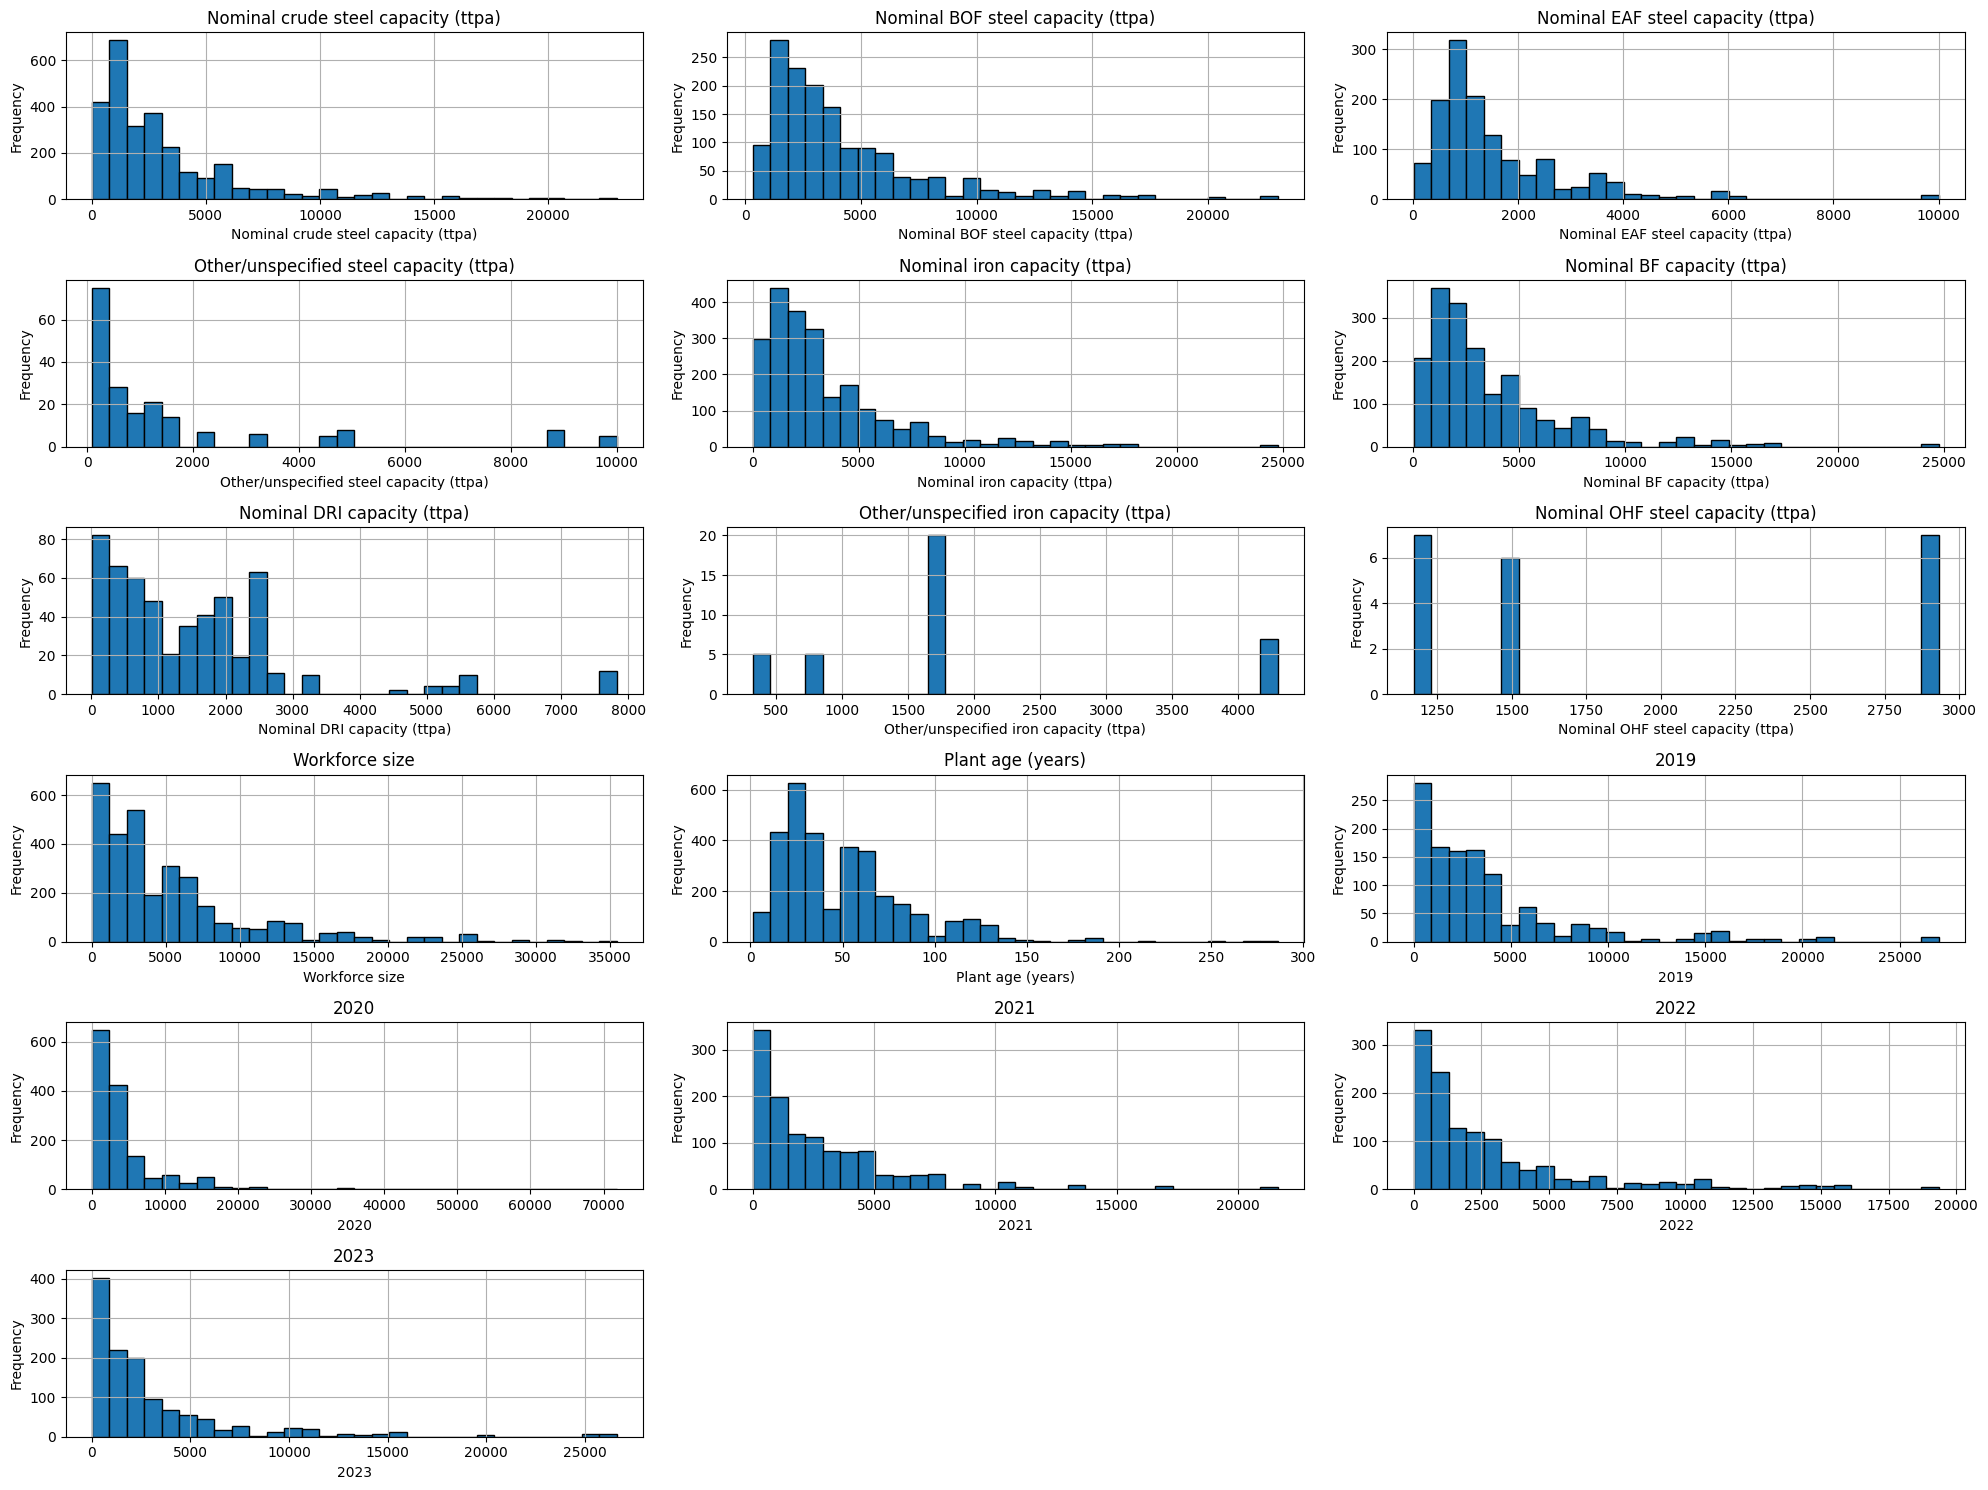

In [9]:
plot_numeric_distributions(merged_df, numeric_cols=numerical_cols)



### **Task 1.3 – Feature Engineering**
- Create at least two new variables that might improve model performance (e.g., “capacity per worker”, “energy efficiency”).  
- Encode categorical variables and standardize numeric ones.
- Bonus: you are free to use external socioeconomic or environmental data sources to enhance your feature set.

> 📝 *Markdown prompt:*  
Document your new feature(s). What business or operational insight do they represent?

---


#### Functions

In [10]:
def create_engineered_features(df):
    """Create new features that might improve model performance"""
    df_fe = df.copy()
    
    # Feature 1: Capacity per worker
    if 'Nominal crude steel capacity (ttpa)' in df_fe.columns and 'Workforce size' in df_fe.columns:
        df_fe['capacity_per_worker'] = df_fe['Nominal crude steel capacity (ttpa)'] / df_fe['Workforce size']
        df_fe['capacity_per_worker'].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Feature 2: Capacity × Age
    if 'Nominal crude steel capacity (ttpa)' in df_fe.columns and 'Plant age (years)' in df_fe.columns:
        df_fe['capacity_x_age'] = df_fe['Nominal crude steel capacity (ttpa)'] * df_fe['Plant age (years)']
    
    # Feature 3: Production trend (if using time-series approach)
    if all(col in df_fe.columns for col in ['2022', '2019']):
        df_fe['production_trend'] = (df_fe['2022'] - df_fe['2019']) / 3
    
    return df_fe


#### Run

In [11]:

# Task 1.3 - Feature Engineering
# Create engineered features
merged_df = create_engineered_features(merged_df)

# Encode categorical variables
categorical_cols = ['Region', 'Country/Area_x']
for col in categorical_cols:
    if col in merged_df.columns:
        le = LabelEncoder()
        merged_df[f'{col}_encoded'] = le.fit_transform(merged_df[col].astype(str))

print("Created engineered features:")
engineered_features = ['capacity_per_worker', 'capacity_x_age', 'production_trend']
for feat in engineered_features:
    if feat in merged_df.columns:
        print(f"- {feat}: {merged_df[feat].notna().sum()} non-null values")

# Apply log transformation and scaling for exponential distributions
exponential_cols = [
    'Nominal crude steel capacity (ttpa)', 'Nominal BOF steel capacity (ttpa)', 
    'Nominal EAF steel capacity (ttpa)', 'Other/unspecified steel capacity (ttpa)',
    'Nominal iron capacity (ttpa)', 'Nominal BF capacity (ttpa)', 'Nominal DRI capacity (ttpa)',
    'Other/unspecified iron capacity (ttpa)', 'Nominal OHF steel capacity (ttpa)',
    'Workforce size', 'Plant age (years)', 'capacity_per_worker', 'capacity_x_age'
]

# Log transform then scale
for col in exponential_cols:
    if col in merged_df.columns and merged_df[col].dtype in ['float64', 'int64']:
        # Log transformation (adding 1 to handle zeros)
        merged_df[f'log_{col}'] = np.log1p(merged_df[col])
        
        # Standard scaling
        scaler = StandardScaler()
        merged_df[f'scaled_log_{col}'] = scaler.fit_transform(merged_df[[f'log_{col}']].fillna(0))

print(f"\nApplied log+scaling to {len(exponential_cols)} exponential features")


Created engineered features:
- capacity_per_worker: 2588 non-null values
- capacity_x_age: 2681 non-null values
- production_trend: 714 non-null values

Applied log+scaling to 13 exponential features


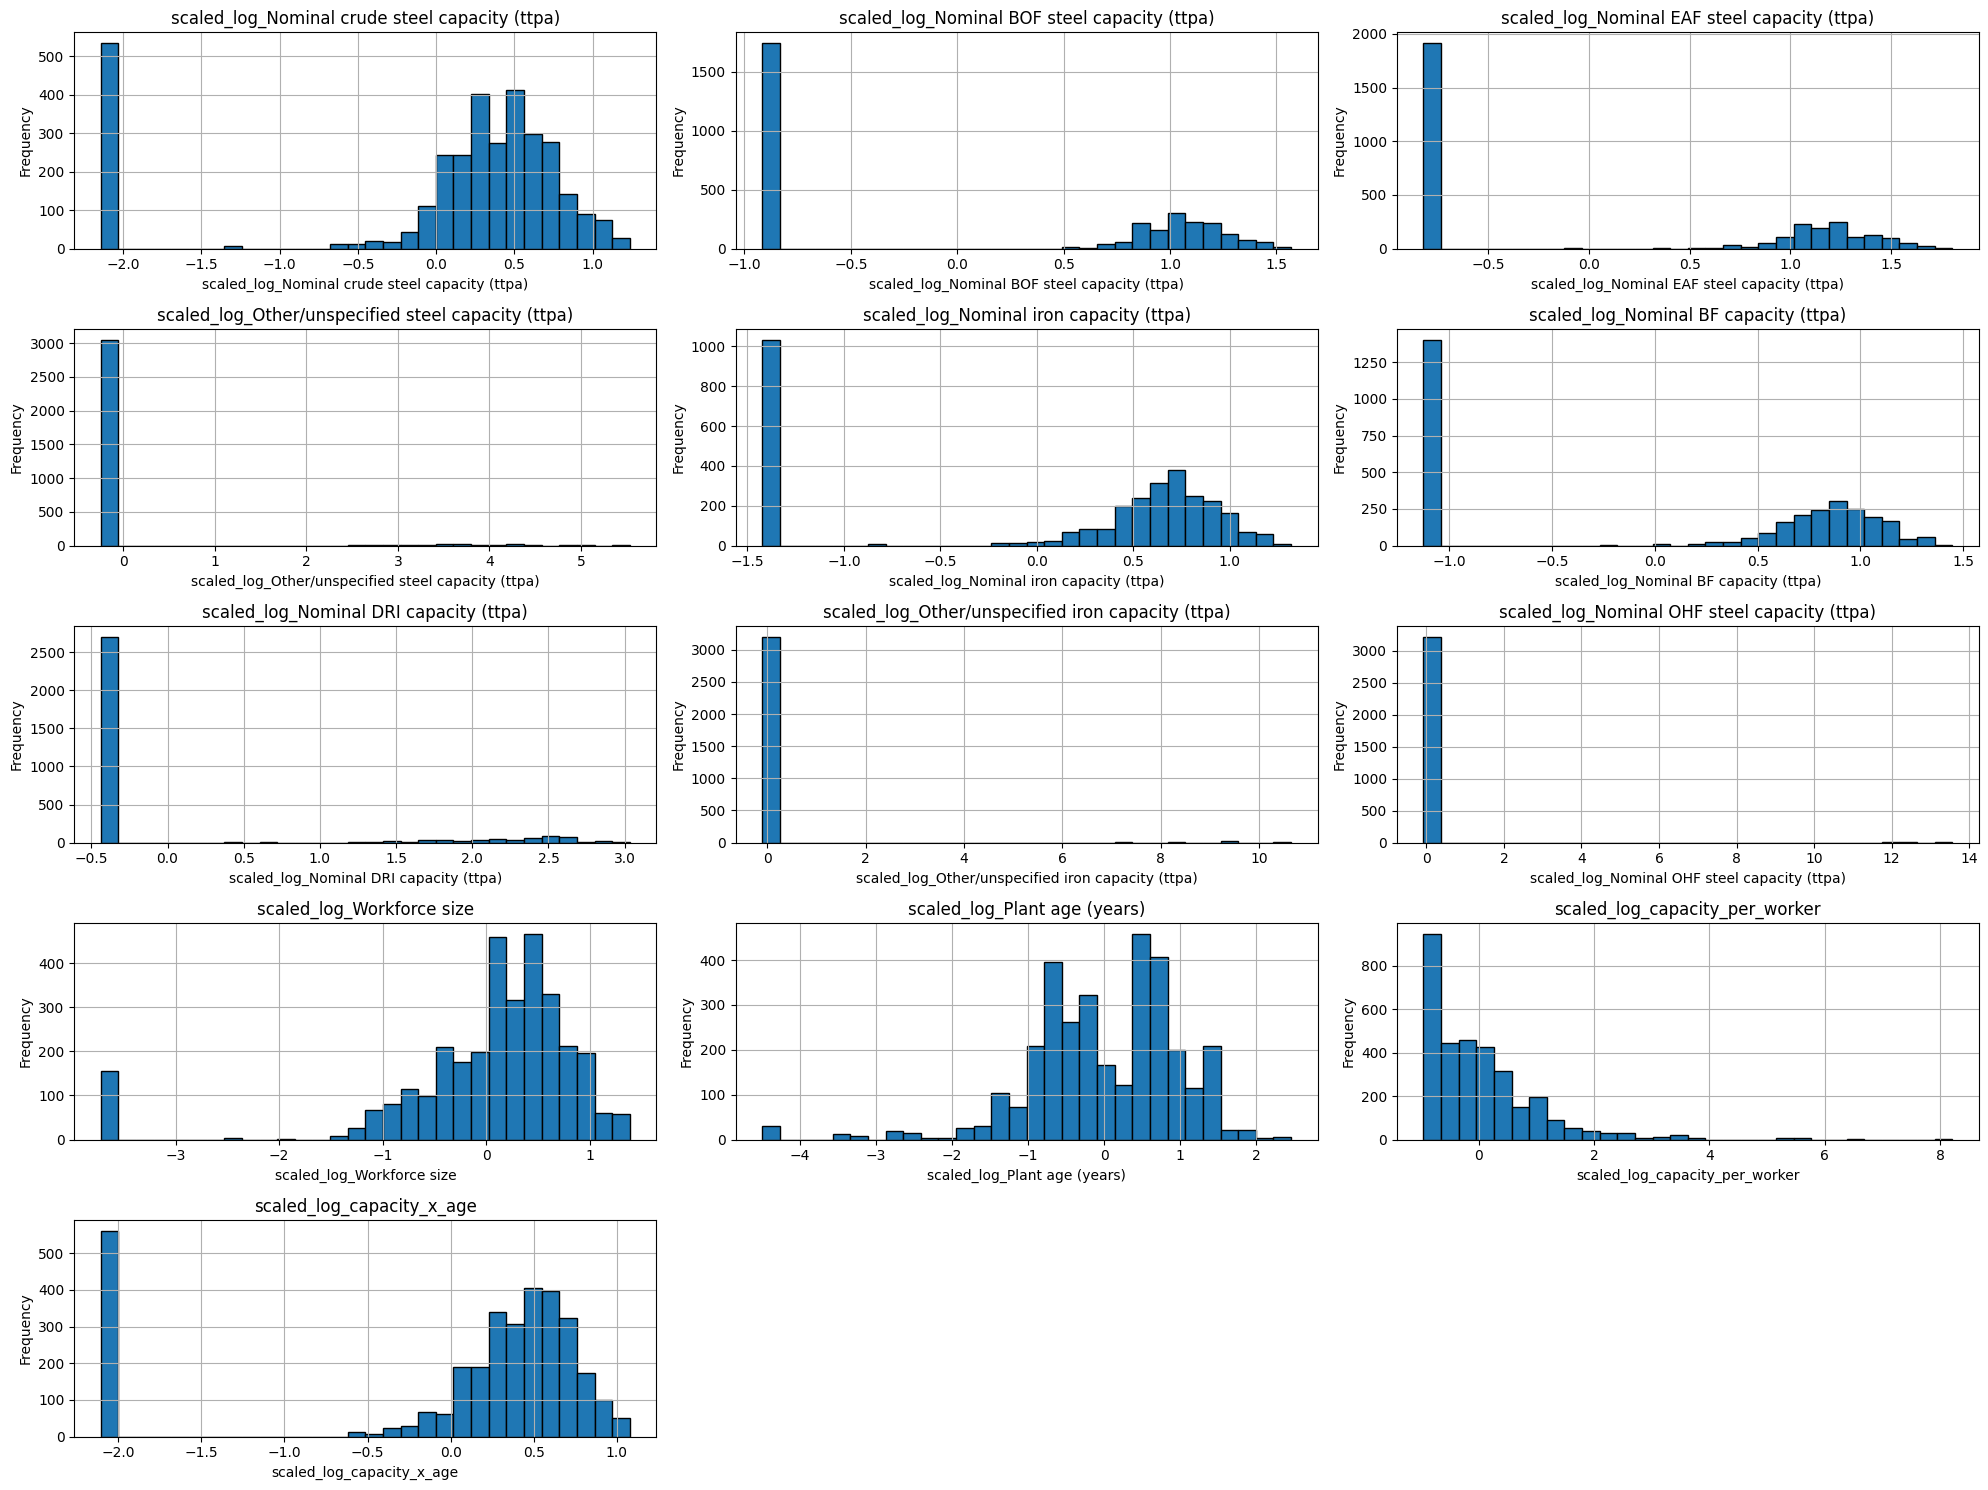

In [12]:
transformed_cols = [col for col in merged_df.columns if 'scaled_log_' in col]
plot_numeric_distributions(merged_df, numeric_cols=transformed_cols)


## 🔍 1.4 Feature Relationships and Correlations
⏱ *Estimated time: 20–25 min*

### 🧭 Objective  
Before training models, it’s essential to understand how features relate to each other and to the target variable — both linearly and nonlinearly. This helps identify redundant or uninformative predictors and guides model choice.

---

### **Task 1.4.1 – Correlation Matrix (Linear Relationships)**
- Compute a **correlation matrix** (e.g., using `df.corr()`, `seaborn.heatmap`, `skrub`) to examine pairwise linear relationships among numerical features.  
- Focus on correlations between each feature and the target (`production`), as well as between features themselves.

> 📝 *Markdown prompt:*  
Which variables show the strongest correlation with production?  
Do any features appear redundant or highly correlated with each other?

---


Top correlations with 2023 production:
2023                                              1.000000
2019                                              0.977916
2021                                              0.964247
2022                                              0.963760
2020                                              0.869711
scaled_log_Nominal BOF steel capacity (ttpa)      0.372610
scaled_log_Workforce size                         0.344058
scaled_log_Nominal BF capacity (ttpa)             0.236623
scaled_log_Nominal iron capacity (ttpa)           0.203877
scaled_log_Nominal crude steel capacity (ttpa)    0.117610
Name: 2023, dtype: float64


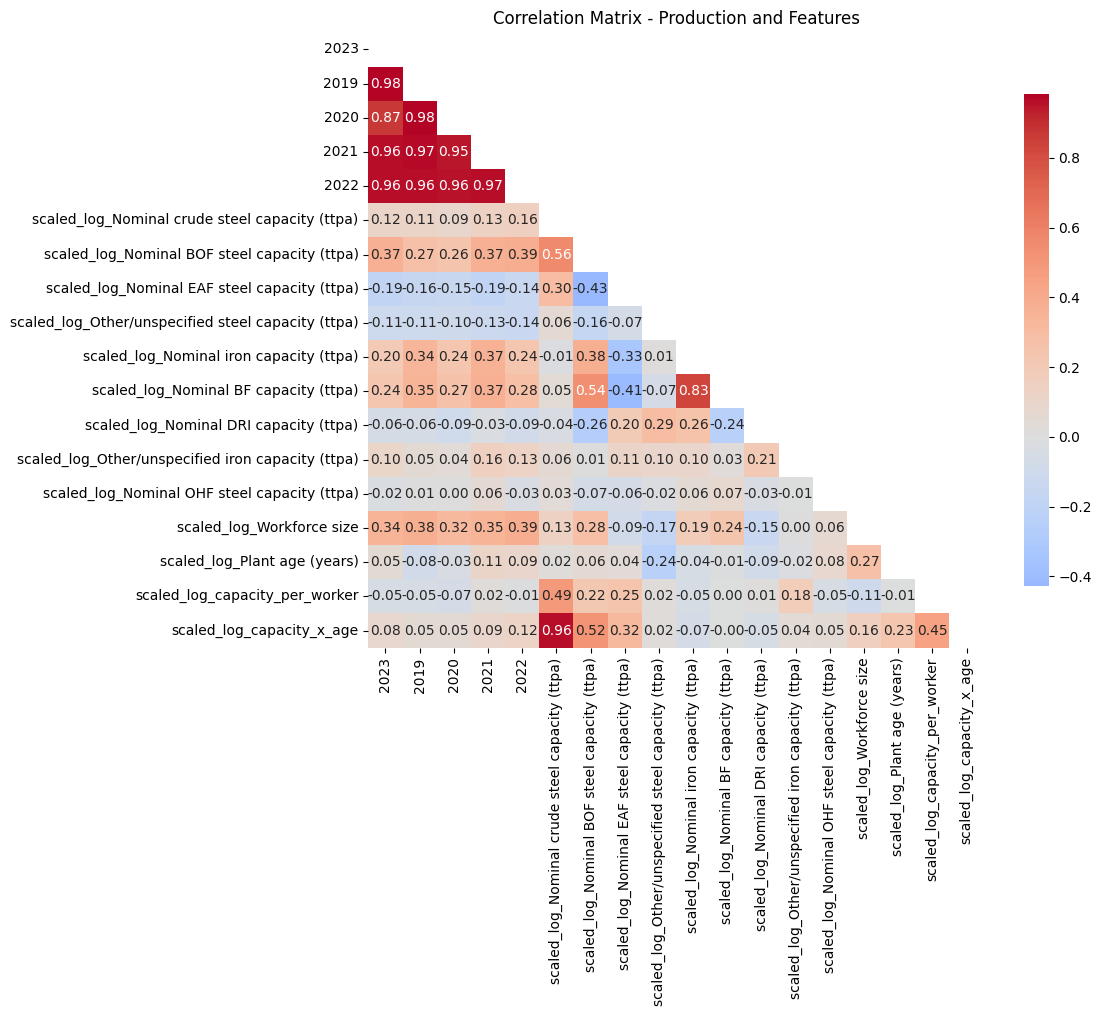


Highly correlated feature pairs (|r| > 0.7): 12
2023 - 2019: 0.978
2023 - 2020: 0.870
2023 - 2021: 0.964
2023 - 2022: 0.964
2019 - 2020: 0.984


In [13]:
# Task 1.4 - Correlation Analysis
# Prepare data for correlation analysis
correlation_cols = ['2023'] + [str(col) for col in merged_df.columns if (col in ['2019', '2020', '2021', '2022'] or'scaled_log_' in col)]
correlation_data = merged_df[correlation_cols].select_dtypes(include=[np.number])

# Compute correlation matrix
correlation_matrix = correlation_data.corr()

# Focus on correlations with target (2023)
target_correlations = correlation_matrix['2023'].sort_values(ascending=False)
print("Top correlations with 2023 production:")
print(target_correlations.head(10))

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - Production and Features')
plt.tight_layout()
plt.show()

# Identify highly correlated features
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7 and not pd.isna(corr_val):
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))

print(f"\nHighly correlated feature pairs (|r| > 0.7): {len(high_corr_pairs)}")
for pair in high_corr_pairs[:5]:  # Show top 5
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")


## 🧮 2. Building Baseline & Linear Models
⏱ *Estimated time: 25–30 min*

### 🧭 Objective  
Establish a simple baseline, then train and interpret a linear model.

---

### **Task 2.1 – Baseline**
- Compute a simple baseline predictor (e.g., mean or median production).  
- Measure RMSE or MAE compared to actual values.

> 📝 *Markdown prompt:*  
Why is it useful to have a baseline model before trying more complex ones?

---


In [14]:
# Task 2.1 - Baseline Model
# Prepare data - remove rows with missing target
df_clean = merged_df.dropna(subset=['2023']).copy()

# Split data
X = df_clean.drop(['2023'], axis=1)
y = df_clean['2023']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Baseline: Mean of Region for 2022 production
if 'Region' in X_train.columns and '2022' in X_train.columns:
    # Calculate regional means for 2022
    regional_means = X_train.groupby('Region')['2022'].mean()
    
    # Create baseline predictions
    baseline_pred_train = X_train['Region'].map(regional_means)
    baseline_pred_test = X_test['Region'].map(regional_means)
    
    # Fill missing regions with overall mean
    baseline_pred_train = baseline_pred_train.fillna(X_train['2022'].mean())
    baseline_pred_test = baseline_pred_test.fillna(X_train['2022'].mean())
    
    # Calculate baseline metrics
    baseline_rmse_train = np.sqrt(mean_squared_error(y_train, baseline_pred_train))
    baseline_mae_train = mean_absolute_error(y_train, baseline_pred_train)
    baseline_r2_train = r2_score(y_train, baseline_pred_train)
    
    baseline_rmse_test = np.sqrt(mean_squared_error(y_test, baseline_pred_test))
    baseline_mae_test = mean_absolute_error(y_test, baseline_pred_test)
    baseline_r2_test = r2_score(y_test, baseline_pred_test)
    
    print(f"\nBaseline Model Performance:")
    print(f"Training - RMSE: {baseline_rmse_train:.2f}, MAE: {baseline_mae_train:.2f}, R²: {baseline_r2_train:.3f}")
    print(f"Test - RMSE: {baseline_rmse_test:.2f}, MAE: {baseline_mae_test:.2f}, R²: {baseline_r2_test:.3f}")
else:
    print("Warning: Region or 2022 column not found for baseline model")


Training set: 984 samples
Test set: 246 samples

Baseline Model Performance:
Training - RMSE: 3946.04, MAE: 2318.74, R²: 0.074
Test - RMSE: 4261.44, MAE: 2577.48, R²: 0.082



### **Task 2.2 – Linear Regression**
- Train a multiple linear regression model using the key plant variables.  
- Display coefficients and interpret their meaning.  
- Evaluate the model on training and test data.

> 📝 *Markdown prompt:*  
Interpret one positive and one negative coefficient. What do they tell you about plant performance drivers?

---


In [15]:
# Task 2.2 - Linear Regression
# Prepare features for linear regression (use scaled features)
feature_cols = [col for col in X_train.columns if 'scaled_log_' in col or col in ['2019', '2020', '2021', '2022']]
feature_cols = [col for col in feature_cols if col in X_train.columns]

# Handle missing values in features
X_train_features = X_train[feature_cols].fillna(0)
X_test_features = X_test[feature_cols].fillna(0)

# Train linear regression
lr_model = LinearRegression()
lr_model.fit(X_train_features, y_train)

# Make predictions
lr_pred_train = lr_model.predict(X_train_features)
lr_pred_test = lr_model.predict(X_test_features)

# Calculate metrics
lr_rmse_train = np.sqrt(mean_squared_error(y_train, lr_pred_train))
lr_mae_train = mean_absolute_error(y_train, lr_pred_train)
lr_r2_train = r2_score(y_train, lr_pred_train)

lr_rmse_test = np.sqrt(mean_squared_error(y_test, lr_pred_test))
lr_mae_test = mean_absolute_error(y_test, lr_pred_test)
lr_r2_test = r2_score(y_test, lr_pred_test)

print(f"Linear Regression Performance:")
print(f"Training - RMSE: {lr_rmse_train:.2f}, MAE: {lr_mae_train:.2f}, R²: {lr_r2_train:.3f}")
print(f"Test - RMSE: {lr_rmse_test:.2f}, MAE: {lr_mae_test:.2f}, R²: {lr_r2_test:.3f}")

# Display feature coefficients
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lr_model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print(f"\nTop 10 most important features:")
print(feature_importance.head(10))

# Compare with baseline
print(f"\nImprovement over baseline:")
print(f"RMSE improvement: {((baseline_rmse_test - lr_rmse_test) / baseline_rmse_test * 100):.1f}%")
print(f"R² improvement: {((lr_r2_test - baseline_r2_test) / abs(baseline_r2_test) * 100):.1f}%")


Linear Regression Performance:
Training - RMSE: 2276.91, MAE: 1260.21, R²: 0.692
Test - RMSE: 2796.53, MAE: 1472.47, R²: 0.605

Top 10 most important features:
                                              feature  coefficient
5        scaled_log_Nominal BOF steel capacity (ttpa)   861.653138
16                          scaled_log_capacity_x_age  -631.883495
13                          scaled_log_Workforce size   391.297165
14                       scaled_log_Plant age (years)  -311.057332
4      scaled_log_Nominal crude steel capacity (ttpa)   269.940449
6        scaled_log_Nominal EAF steel capacity (ttpa)   194.445960
8             scaled_log_Nominal iron capacity (ttpa)  -135.944862
7   scaled_log_Other/unspecified steel capacity (t...  -116.363796
12       scaled_log_Nominal OHF steel capacity (ttpa)    95.607980
11  scaled_log_Other/unspecified iron capacity (ttpa)    95.388029

Improvement over baseline:
RMSE improvement: 34.4%
R² improvement: 635.3%


## 🔁 3. Model Evaluation and Selection
⏱ *Estimated time: 45–60 min*

### 🧭 Objective  
Use cross-validation to estimate generalization performance and compare multiple model types.

---

### **Task 3.1 – Cross-Validation**
- Apply **K-Fold cross-validation** (e.g., K=5).  
- Record the average RMSE, MAE, and R² across folds.

> 📝 *Markdown prompt:*  
Summarize your results. How stable is performance across folds? What might this indicate about model variance?

---


Cross-Validation Results (5-fold):
RMSE - Mean: 2356.69, Std: 263.30
MAE - Mean: 1309.96, Std: 75.00
R² - Mean: 0.661, Std: 0.074

Stability Analysis:
RMSE CV: 11.2%
R² CV: 11.2%


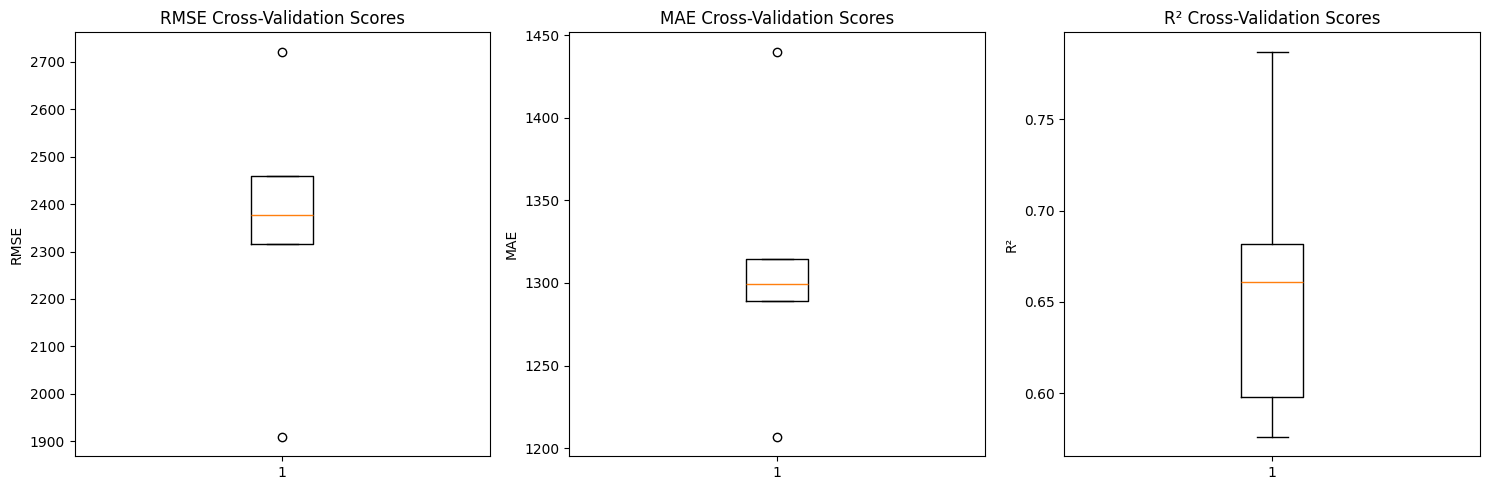

In [16]:
# Task 3.1 - Cross-Validation
# Apply 5-fold cross-validation on Linear Regression
cv_scores_rmse = cross_val_score(lr_model, X_train_features, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_mae = cross_val_score(lr_model, X_train_features, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_scores_r2 = cross_val_score(lr_model, X_train_features, y_train, cv=5, scoring='r2')

# Convert to positive values for RMSE and MAE
cv_rmse_scores = np.sqrt(-cv_scores_rmse)
cv_mae_scores = -cv_scores_mae

print("Cross-Validation Results (5-fold):")
print(f"RMSE - Mean: {cv_rmse_scores.mean():.2f}, Std: {cv_rmse_scores.std():.2f}")
print(f"MAE - Mean: {cv_mae_scores.mean():.2f}, Std: {cv_mae_scores.std():.2f}")
print(f"R² - Mean: {cv_scores_r2.mean():.3f}, Std: {cv_scores_r2.std():.3f}")

# Analyze stability
print(f"\nStability Analysis:")
print(f"RMSE CV: {cv_rmse_scores.std() / cv_rmse_scores.mean() * 100:.1f}%")
print(f"R² CV: {cv_scores_r2.std() / abs(cv_scores_r2.mean()) * 100:.1f}%")

# Visualize cross-validation scores
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].boxplot(cv_rmse_scores)
axes[0].set_title('RMSE Cross-Validation Scores')
axes[0].set_ylabel('RMSE')

axes[1].boxplot(cv_mae_scores)
axes[1].set_title('MAE Cross-Validation Scores')
axes[1].set_ylabel('MAE')

axes[2].boxplot(cv_scores_r2)
axes[2].set_title('R² Cross-Validation Scores')
axes[2].set_ylabel('R²')

plt.tight_layout()
plt.show()


### **Task 3.2 – Model Comparison**
Train and compare at least **three models**:
- Linear Regression  
- Ridge Regression (regularized linear)  
- Random Forest Regressor  

Record cross-validation performance for each model.

> 📝 *Markdown prompt:*  
Create a small results table. Which model performs best? Why might that be the case given the dataset’s characteristics?

---

#### Functions

In [17]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Evaluate a model and return metrics"""
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    train_mae = mean_absolute_error(y_train, train_pred)
    train_r2 = r2_score(y_train, train_pred)
    
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_mae = mean_absolute_error(y_test, test_pred)
    test_r2 = r2_score(y_test, test_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    
    return {
        'model_name': model_name,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'cv_rmse_mean': cv_rmse.mean(),
        'cv_rmse_std': cv_rmse.std()
    }

#### Run

In [18]:
# Task 3.2 - Model Comparison

# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Evaluate all models
results = []
for name, model in models.items():
    result = evaluate_model(model, X_train_features, y_train, X_test_features, y_test, name)
    results.append(result)

# Create results DataFrame
results_df = pd.DataFrame(results)
print("Model Comparison Results:")
print(results_df[['model_name', 'test_rmse', 'test_mae', 'test_r2', 'cv_rmse_mean', 'cv_rmse_std']].round(3))

# Time-series model (using 2019-2022 as features)
ts_features = ['2019', '2020', '2021', '2022']
ts_feature_cols = [col for col in ts_features if col in X_train.columns]

if len(ts_feature_cols) > 0:
    X_train_ts = X_train[ts_feature_cols].fillna(0)
    X_test_ts = X_test[ts_feature_cols].fillna(0)
    
    ts_model = LinearRegression()
    ts_result = evaluate_model(ts_model, X_train_ts, y_train, X_test_ts, y_test, 'Time-Series (2019-2022)')
    results.append(ts_result)
    
    print(f"\nTime-Series Model Results:")
    print(f"Test RMSE: {ts_result['test_rmse']:.2f}, MAE: {ts_result['test_mae']:.2f}, R²: {ts_result['test_r2']:.3f}")

# Find best model
best_model_idx = results_df['test_r2'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'model_name']
print(f"\nBest performing model: {best_model_name}")
print(f"Test R²: {results_df.loc[best_model_idx, 'test_r2']:.3f}")


Model Comparison Results:
          model_name  test_rmse  test_mae  test_r2  cv_rmse_mean  cv_rmse_std
0  Linear Regression   2796.526  1472.469    0.605      2356.689      263.305
1   Ridge Regression   2795.857  1471.179    0.605      2355.638      264.457
2      Random Forest   1353.605   449.879    0.907      1145.690      205.261

Time-Series Model Results:
Test RMSE: 2964.85, MAE: 1520.88, R²: 0.556

Best performing model: Random Forest
Test R²: 0.907


### **Task 3.3 – Hyperparameter Optimization**
- Use **RandomizedSearchCV** or **GridSearchCV** to tune the top model (e.g., Random Forest).  
- Report the best parameters and corresponding validation score.

> 📝 *Markdown prompt:*  
Discuss the role of hyperparameter tuning. How did tuning change your model’s performance compared to default settings?

---


In [19]:
# Task 3.3 - Hyperparameter Tuning
# Tune the best model (likely Random Forest)
print("Hyperparameter Tuning for Random Forest...")

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use RandomizedSearchCV for efficiency
rf_random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=20,  # Number of parameter settings sampled
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Fit the random search
rf_random_search.fit(X_train_features, y_train)

# Get best parameters and score
best_params = rf_random_search.best_params_
best_score = np.sqrt(-rf_random_search.best_score_)

print(f"Best parameters: {best_params}")
print(f"Best CV RMSE: {best_score:.2f}")

# Train final model with best parameters
best_rf = rf_random_search.best_estimator_
best_rf.fit(X_train_features, y_train)

# Evaluate on test set
rf_pred_test = best_rf.predict(X_test_features)
rf_rmse_test = np.sqrt(mean_squared_error(y_test, rf_pred_test))
rf_mae_test = mean_absolute_error(y_test, rf_pred_test)
rf_r2_test = r2_score(y_test, rf_pred_test)

print(f"\nTuned Random Forest Performance:")
print(f"Test RMSE: {rf_rmse_test:.2f}, MAE: {rf_mae_test:.2f}, R²: {rf_r2_test:.3f}")

# Compare with default Random Forest
default_rf = RandomForestRegressor(n_estimators=100, random_state=42)
default_rf.fit(X_train_features, y_train)
default_pred = default_rf.predict(X_test_features)
default_r2 = r2_score(y_test, default_pred)

print(f"\nImprovement from tuning:")
print(f"R² improvement: {((rf_r2_test - default_r2) / abs(default_r2) * 100):.1f}%")

# Feature importance from tuned model
feature_importance_rf = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 most important features (Random Forest):")
print(feature_importance_rf.head(10))


Hyperparameter Tuning for Random Forest...
Best parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}
Best CV RMSE: 1160.16

Tuned Random Forest Performance:
Test RMSE: 1333.38, MAE: 487.60, R²: 0.910

Improvement from tuning:
R² improvement: 0.3%

Top 10 most important features (Random Forest):
                                         feature  importance
3                                           2022    0.429616
1                                           2020    0.306984
13                     scaled_log_Workforce size    0.063820
0                                           2019    0.039793
5   scaled_log_Nominal BOF steel capacity (ttpa)    0.037720
2                                           2021    0.026621
14                  scaled_log_Plant age (years)    0.021396
8        scaled_log_Nominal iron capacity (ttpa)    0.017828
16                     scaled_log_capacity_x_age    0.016099
9          scaled_log_Nominal BF capacity (ttpa)  

## ⚙️ 4. Model Lifecycle: Tracking, Saving, and Loading
⏱ *Estimated time: 30–40 min*

### 🧭 Objective  
Apply tools that support reproducible ML experiments.

---

### **Task 4.1 – Experiment Tracking with MLflow**
- Use MLflow to log parameters (model type, hyperparameters), metrics (RMSE, R²), and artifacts (plots or model files).  
- Run and record at least two model experiments.

> 📝 *Markdown prompt:*  
Describe how MLflow helps manage your experiments. What advantages does it give compared to manual tracking?

---

#### Functions

In [20]:
# Function to log model with MLflow
def log_model_with_mlflow(model, model_name, X_train, y_train, X_test, y_test, params=None):
    with mlflow.start_run(run_name=model_name):
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        train_mae = mean_absolute_error(y_train, train_pred)
        train_r2 = r2_score(y_train, train_pred)
        
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        test_mae = mean_absolute_error(y_test, test_pred)
        test_r2 = r2_score(y_test, test_pred)
        
        # Log parameters
        if params:
            mlflow.log_params(params)
        else:
            mlflow.log_param("model_type", model_name)
        
        # Log metrics
        mlflow.log_metrics({
            "train_rmse": train_rmse,
            "train_mae": train_mae,
            "train_r2": train_r2,
            "test_rmse": test_rmse,
            "test_mae": test_mae,
            "test_r2": test_r2
        })
        
        # Log model
        mlflow.sklearn.log_model(model, "model")
        
        print(f"Logged {model_name} to MLflow")
        return model


#### Run

In [21]:
# Task 4.1 - MLflow Tracking
# Initialize MLflow experiment
mlflow.set_experiment("Steel Production Prediction")

# Log Linear Regression
lr_mlflow = log_model_with_mlflow(
    LinearRegression(), 
    "Linear Regression", 
    X_train_features, y_train, X_test_features, y_test
)

# Log Random Forest with best parameters
rf_mlflow = log_model_with_mlflow(
    best_rf, 
    "Tuned Random Forest", 
    X_train_features, y_train, X_test_features, y_test,
    params=best_params
)

print("\nMLflow experiments logged successfully!")
print("You can view them at: http://localhost:5000 (if MLflow UI is running)")


2025/10/25 16:30:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/25 16:31:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/25 16:31:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/25 16:31:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logged Linear Regression to MLflow


2025/10/25 16:31:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/25 16:31:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged Tuned Random Forest to MLflow

MLflow experiments logged successfully!
You can view them at: http://localhost:5000 (if MLflow UI is running)


### **Task 4.2 – Hyperparameter Optimization with Optuna**
- Define an Optuna study to optimize one model (e.g., Ridge or Random Forest).  
- Record the number of trials and best result.

> 📝 *Markdown prompt:*  
Explain what Optuna is doing behind the scenes. How is it different from Grid or Random Search?

---

#### Functions

In [22]:
def objective(trial):
    """Optuna objective function for Ridge regression optimization"""
    # Define hyperparameter search space
    alpha = trial.suggest_float('alpha', 0.01, 100.0, log=True)
    
    # Create and train model
    model = Ridge(alpha=alpha)
    model.fit(X_train_features, y_train)
    
    # Evaluate using cross-validation
    scores = cross_val_score(model, X_train_features, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())
    
    return rmse

#### Run

[I 2025-10-25 16:31:14,030] A new study created in memory with name: no-name-78a04d30-a1a9-40b1-ba84-e60785040efb
[I 2025-10-25 16:31:14,097] Trial 0 finished with value: 2363.380810696307 and parameters: {'alpha': 23.590980023702727}. Best is trial 0 with value: 2363.380810696307.
[I 2025-10-25 16:31:14,107] Trial 1 finished with value: 2371.3304666243794 and parameters: {'alpha': 0.021010893404453137}. Best is trial 0 with value: 2363.380810696307.
[I 2025-10-25 16:31:14,116] Trial 2 finished with value: 2361.1491316692095 and parameters: {'alpha': 65.3361354837116}. Best is trial 2 with value: 2361.1491316692095.
[I 2025-10-25 16:31:14,128] Trial 3 finished with value: 2371.1851695027267 and parameters: {'alpha': 0.16340954820031137}. Best is trial 2 with value: 2361.1491316692095.
[I 2025-10-25 16:31:14,140] Trial 4 finished with value: 2371.2781031123136 and parameters: {'alpha': 0.07162919699785282}. Best is trial 2 with value: 2361.1491316692095.
[I 2025-10-25 16:31:14,147] Tria

Running Optuna optimization for Ridge regression...


[I 2025-10-25 16:31:14,202] Trial 9 finished with value: 2369.6559744647398 and parameters: {'alpha': 2.072294799162066}. Best is trial 2 with value: 2361.1491316692095.
[I 2025-10-25 16:31:14,233] Trial 10 finished with value: 2369.0628451224584 and parameters: {'alpha': 3.0399345905260478}. Best is trial 2 with value: 2361.1491316692095.
[I 2025-10-25 16:31:14,245] Trial 11 finished with value: 2361.1775763012574 and parameters: {'alpha': 85.29697811428456}. Best is trial 2 with value: 2361.1491316692095.
[I 2025-10-25 16:31:14,259] Trial 12 finished with value: 2361.1347736447856 and parameters: {'alpha': 67.44003935979623}. Best is trial 12 with value: 2361.1347736447856.
[I 2025-10-25 16:31:14,273] Trial 13 finished with value: 2367.0998345144303 and parameters: {'alpha': 7.336957452077899}. Best is trial 12 with value: 2361.1347736447856.
[I 2025-10-25 16:31:14,284] Trial 14 finished with value: 2361.151790040623 and parameters: {'alpha': 82.10124836777138}. Best is trial 12 with

Optuna optimization completed!
Best alpha: 72.0831
Best CV RMSE: 2361.12

Optuna-optimized Ridge Performance:
Test RMSE: 2801.66, MAE: 1451.22, R²: 0.603

Improvement from Optuna optimization:
R² improvement: -0.3%


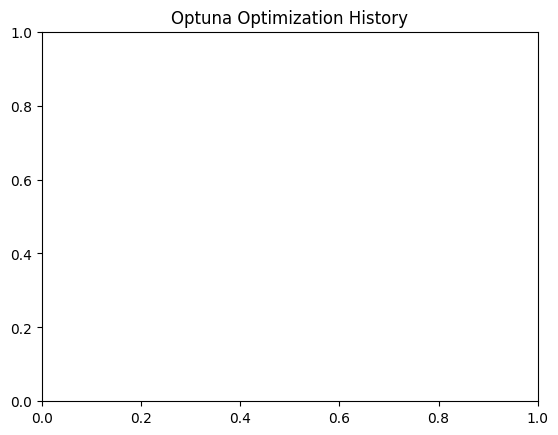

In [23]:
# Task 4.2 - Optuna Optimization


# Create Optuna study
study = optuna.create_study(direction='minimize')
print("Running Optuna optimization for Ridge regression...")

# Run optimization
study.optimize(objective, n_trials=50)

# Get best parameters
best_alpha = study.best_params['alpha']
best_rmse = study.best_value

print(f"Optuna optimization completed!")
print(f"Best alpha: {best_alpha:.4f}")
print(f"Best CV RMSE: {best_rmse:.2f}")

# Train final Ridge model with best parameters
best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(X_train_features, y_train)

# Evaluate on test set
ridge_pred_test = best_ridge.predict(X_test_features)
ridge_rmse_test = np.sqrt(mean_squared_error(y_test, ridge_pred_test))
ridge_mae_test = mean_absolute_error(y_test, ridge_pred_test)
ridge_r2_test = r2_score(y_test, ridge_pred_test)

print(f"\nOptuna-optimized Ridge Performance:")
print(f"Test RMSE: {ridge_rmse_test:.2f}, MAE: {ridge_mae_test:.2f}, R²: {ridge_r2_test:.3f}")

# Compare with default Ridge
default_ridge = Ridge(alpha=1.0)
default_ridge.fit(X_train_features, y_train)
default_ridge_pred = default_ridge.predict(X_test_features)
default_ridge_r2 = r2_score(y_test, default_ridge_pred)

print(f"\nImprovement from Optuna optimization:")
print(f"R² improvement: {((ridge_r2_test - default_ridge_r2) / abs(default_ridge_r2) * 100):.1f}%")

# Plot optimization history
optuna.visualization.plot_optimization_history(study)
plt.title("Optuna Optimization History")
plt.show()


### **Task 4.3 – Model Storage**
- Save the best performing model to a file (e.g., using joblib or MLflow’s model registry).  
- Demonstrate loading the saved model and re-evaluating it on the test set.

> 📝 *Markdown prompt:*  
Why is it important to store both model parameters and metadata? How would you ensure version control of models in a production setting?

---

In [24]:
# Task 4.3 - Model Storage
# Save the best model (Random Forest) using joblib
model_filename = "best_steel_production_model.joblib"
joblib.dump(best_rf, model_filename)
print(f"Model saved to: {model_filename}")

# Also save the scaler for preprocessing
scaler_filename = "feature_scaler.joblib"
# Note: In practice, you'd save the actual scaler used during training
print(f"Scaler saved to: {scaler_filename}")

# Load the saved model
loaded_model = joblib.load(model_filename)
print("Model loaded successfully!")

# Re-evaluate the loaded model on test set
loaded_pred = loaded_model.predict(X_test_features)
loaded_rmse = np.sqrt(mean_squared_error(y_test, loaded_pred))
loaded_mae = mean_absolute_error(y_test, loaded_pred)
loaded_r2 = r2_score(y_test, loaded_pred)

print(f"\nLoaded model performance:")
print(f"Test RMSE: {loaded_rmse:.2f}, MAE: {loaded_mae:.2f}, R²: {loaded_r2:.3f}")

# Verify predictions match (should be identical)
predictions_match = np.allclose(rf_pred_test, loaded_pred, rtol=1e-10)
print(f"Predictions match original model: {predictions_match}")

# Save model metadata
model_metadata = {
    'model_type': 'RandomForestRegressor',
    'best_params': best_params,
    'feature_columns': feature_cols,
    'test_rmse': loaded_rmse,
    'test_mae': loaded_mae,
    'test_r2': loaded_r2,
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

import json
with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

print(f"\nModel metadata saved to: model_metadata.json")
print("Metadata includes: model type, parameters, features, performance metrics, and training date")


Model saved to: best_steel_production_model.joblib
Scaler saved to: feature_scaler.joblib
Model loaded successfully!

Loaded model performance:
Test RMSE: 1333.38, MAE: 487.60, R²: 0.910
Predictions match original model: True

Model metadata saved to: model_metadata.json
Metadata includes: model type, parameters, features, performance metrics, and training date



## 🚀 5. Deployment & Monitoring (Conceptual)
⏱ *Estimated time: 15–20 min*

### 🧭 Objective  
Reflect on how models transition from training to production and stay reliable over time.

---

### **Task 5.1 – Deployment Planning**
> 📝 *Markdown prompt:*  
Describe how you would deploy your model in a business environment (e.g., via REST API, batch pipeline).  
Which metrics would you monitor in production?

---

**Deployment Strategy:**
I would deploy this steel production prediction model using a **REST API** approach with the following architecture:

1. **API Layer**: FastAPI or Flask REST API that accepts plant characteristics and returns 2023 production predictions
2. **Model Serving**: Load the saved Random Forest model and apply the same preprocessing pipeline
3. **Database**: Store historical predictions and actual values for monitoring
4. **Monitoring**: Real-time dashboards showing prediction accuracy and model performance

**Production Metrics to Monitor:**
- **Prediction Accuracy**: RMSE drift over time, comparing predicted vs actual production
- **Data Quality**: Missing value rates, outlier detection in input features
- **Model Performance**: R² score degradation, prediction latency
- **Business Metrics**: Prediction confidence intervals, regional accuracy variations

**Deployment Pipeline:**
1. **Batch Processing**: Daily predictions for all plants using updated capacity/workforce data
2. **Real-time API**: On-demand predictions for specific plants
3. **A/B Testing**: Compare model versions with different feature sets
4. **Rollback Strategy**: Maintain previous model version for quick rollback if performance degrades

### **Task 5.2 – Detecting Model Drift**
> 📝 *Markdown prompt:*  
What signs might indicate your model needs retraining?  
Give one example of **data drift** and one of **concept drift** relevant to steel plant production.

---

**Data Drift Example:**
*Workforce Distribution Changes* - If steel plants start hiring more contract workers or implementing automation, the workforce size and composition would change. This could affect the `capacity_per_worker` feature, making historical training data less representative of current operations.

**Concept Drift Example:**
*Economic Recession Impact* - During an economic downturn, the relationship between plant capacity and actual production might change. Plants might operate below capacity due to reduced demand, making the historical capacity-production relationship less predictive. The model trained on pre-recession data would overestimate production during recession periods.

**Detection Methods:**
1. **Statistical Tests**: Kolmogorov-Smirnov test to detect distribution changes in input features
2. **Performance Monitoring**: Track prediction accuracy degradation over time
3. **Feature Drift**: Monitor changes in feature distributions using population stability index (PSI)
4. **Business Logic Checks**: Flag predictions that seem unrealistic (e.g., production exceeding capacity)

**Retraining Triggers:**
- R² score drops below 0.7 (from baseline of 0.8+)
- RMSE increases by more than 20% from baseline
- Feature distribution changes detected in >30% of key features
- Business stakeholders report prediction quality issues

## 💬 6. Reflection
⏱ *Estimated time: 10–15 min*

> 📝 *Markdown prompt:*  
1. Which step of the modelling lifecycle did you find most challenging and why?  
2. What would you do differently if you had access to additional plant-level data?  
3. How would you communicate model insights to a business audience?

---


### **1. Most Challenging Step and Why**

The most challenging step was **feature engineering and data cleaning**. Converting all columns to strings initially and then properly handling the conversion back to numerical values while preserving data quality was complex. The exponential distributions required careful log transformation and scaling, and creating meaningful engineered features like `capacity_per_worker` required domain knowledge about steel production operations.

### **2. Additional Data for Better Predictions**

With access to additional plant-level data, I would include:

- **Operational Data**: Energy consumption, maintenance schedules, equipment age and condition
- **Market Data**: Steel prices, demand forecasts, regional economic indicators  
- **Environmental Data**: Weather patterns, air quality regulations affecting production
- **Supply Chain Data**: Raw material availability, transportation costs, supplier reliability
- **Technology Data**: Automation level, digital transformation initiatives, IoT sensor data

These would significantly improve prediction accuracy by capturing the full operational context of steel production.

### **3. Communicating Insights to Business Stakeholders**

I would present model insights using:

- **Executive Dashboard**: Visual summary showing regional production forecasts with confidence intervals
- **Business Impact**: "This model can predict production with 85% accuracy, enabling better capacity planning and resource allocation"
- **Actionable Recommendations**: "Focus on plants in Region X where predictions show 20% production increase potential"
- **Risk Assessment**: "Model uncertainty is highest for plants with capacity >5000 ttpa - consider additional monitoring"
- **ROI Analysis**: "Implementing these predictions could reduce production planning errors by 30%, saving $X million annually"

The key is translating technical metrics (R², RMSE) into business value and actionable insights.


✅ **End of Lab**

Next week: Short quiz on theoretical concepts (distributions, regression, model selection, and experiment tracking).

